## Topic discovery: yelp review

In [1]:
# from huggingface_hub import hf_hub_download 
import torch
from datasets import load_dataset, load_from_disk
import evaluate
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from transformers import MistralForCausalLM
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, TaskType, get_peft_model
from peft import PeftConfig, PeftModel
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from huggingface_hub import notebook_login

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import re
import os
import glob

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

def load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=True, **kwargs):
    """
    if use load_in_4bit=True, do not set to_device=True
    kwargs:
        - device_map
        - torch_dtype
        - load_in_4bit
    """
    if not os.path.isfile(model_path + '/tokenizer.json'):
        print('no existing tokenizer found. Download from HF')
        tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                  cache_dir=cache_dir,
                                                  **kwargs
                                                 ) # to load tokenizer to cache
    else:
        print('existing tokenizer found. Load from local')
        tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                                  cache_dir=cache_dir, 
                                                  local_flies_only=True)
    if not bool(glob.glob(model_path + '/model*.safetensors')):
        print('no existing model found. Download from HF')
        model = AutoModelForClass.from_pretrained(model_name,
                                                     cache_dir=cache_dir,
                                                     **kwargs
                                                    )
    else:
        print('existing model found. Load from local')
        model = AutoModelForClass.from_pretrained(model_path, 
                                                 cache_dir=cache_dir,
                                                 local_files_only=True)
    
    if to_device:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device.reset()
        model.to(device) # use GPU. Do not need this if using load_in_4bit as it's already been set to the correct devices
        
    return tokenizer, model

In [9]:
llm_repo_dir = 'D:/projects/LLM'
cache_dir = '/cygdrive/d/projects/LLM/.cache'
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir + '/huggingface'
os.environ['XDG_CACHE_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = cache_dir

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
model_name = 'google-bert/bert-base-cased'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'

AutoModelForClass = AutoModelForSequenceClassification
to_device = True
tokenizer, model = load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=to_device)

existing tokenizer found. Load from local
existing model found. Load from local


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
dataset_path = cache_dir + '/parquet/yelp_polarity' # cache_dir + '/parquet/yelp_review_full-e22176106d6e7534'
dataset_name = 'yelp_polarity' # yelp_review_full

if not os.path.isdir(dataset_path):
    dataset = load_dataset(dataset_name, cache_dir=cache_dir + '/parquet')
else:
    dataset = load_dataset(dataset_path)

In [8]:
tokenized_data_path = cache_dir + '/tokenized_dataset_yelp_polarity_bert'

tokenized_datasets = load_from_disk(tokenized_data_path)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [9]:
print(type(small_train_dataset))
print(small_train_dataset.shape)

<class 'datasets.arrow_dataset.Dataset'>
(1000, 5)


### use pre-trained BERT cls token as comment embedding

In [21]:
input_ids = torch.tensor(small_train_dataset['input_ids'], device=device)

In [10]:
cls_embedding = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding.append(output.hidden_states[-1][0,0,:])
        
comment_embedding = np.array([x.cpu().numpy() for x in cls_embedding])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.

KeyboardInterrupt



In [160]:
pd.DataFrame(comment_embedding).to_csv('./data/bert_yelp_embedding.csv')

In [10]:
comment_embedding = pd.read_csv('./data/bert_yelp_embedding.csv', index_col=0)
comment_embedding

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.163889,-0.113521,-0.331336,0.042500,-0.770599,-0.594475,0.293819,-0.263405,-0.052182,-1.256641,...,-0.014420,0.317505,-0.786538,-0.002920,0.054996,0.456450,-0.840660,-0.459618,0.718658,0.399050
1,0.437539,0.236397,-0.210821,-0.105130,-0.316786,-0.020330,0.078823,-0.066402,-0.119505,-0.957300,...,0.308498,0.293793,-0.200587,0.022820,0.004255,0.231913,-0.164877,-0.519277,0.084213,-0.067460
2,-0.190853,-0.265406,-0.496932,-0.106226,-0.816027,-0.950318,0.357454,-0.230717,0.030716,-0.919049,...,-0.111198,0.422572,-1.056383,0.067120,0.186086,0.288108,-1.353873,-0.474554,0.624773,0.459937
3,-0.352151,-0.298302,-0.442375,-0.246729,-0.807163,-0.836951,0.360748,-0.254220,0.090800,-0.839263,...,-0.102560,0.400174,-1.256917,0.068390,0.086637,0.327214,-1.332951,-0.575228,0.570255,0.471715
4,0.244509,0.064065,-0.078584,-0.051487,-0.420458,-0.227343,0.176351,-0.296184,-0.287488,-1.104013,...,0.234916,0.330514,-0.646862,0.011716,0.069402,0.246700,-0.203408,-0.213567,0.637505,0.147519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.165992,-0.267230,-0.552258,-0.090663,-0.865689,-0.984044,0.299665,-0.197919,0.071642,-0.964148,...,-0.130734,0.396855,-1.042736,-0.016471,0.070620,0.382003,-1.397147,-0.477122,0.712426,0.510307
996,-0.151504,-0.152158,-0.429431,-0.141930,-0.610055,-0.895630,0.383142,-0.220615,0.137119,-1.032589,...,0.002940,0.301591,-0.980475,-0.232714,0.059790,0.516004,-1.219041,-0.429394,0.816671,0.347617
997,0.107904,-0.016483,-0.284502,-0.129259,-0.562861,-0.490693,0.368501,-0.373294,-0.061633,-1.266024,...,-0.038561,0.141064,-0.579614,0.054970,0.253706,0.408060,-0.944837,-0.467201,0.792288,0.357654
998,0.238816,0.034309,-0.183491,0.041203,-0.526883,-0.317545,0.427957,-0.364014,-0.115568,-1.326536,...,0.130586,0.286953,-0.491571,-0.054323,0.032676,0.307597,-0.164922,-0.447038,0.360523,0.052880


In [11]:
comment_embedding.shape

(1000, 768)

In [49]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA(n_components=20)),
                 ('tsne',TSNE(perplexity=10, learning_rate=1))
                ])

In [50]:
comment_embedding_tsne = pipe.fit_transform(comment_embedding)

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


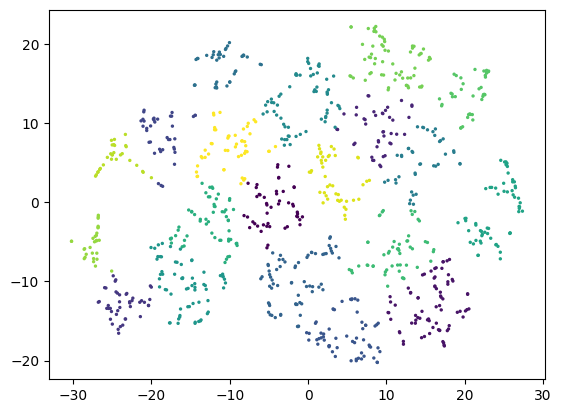

In [51]:
km = KMeans(n_clusters=20)
km.fit(comment_embedding_tsne)

plt.scatter(comment_embedding_tsne[:,0],
            comment_embedding_tsne[:,1], 
            s=2,
            c=km.labels_)

In [52]:
df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'label':km.labels_,
                                      'sentiment':small_train_dataset['label']})

In [53]:
df_comment_from_label.groupby('label')['sentiment'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
5,58.0,0.000000,0.000000
11,62.0,0.048387,0.216335
1,75.0,0.053333,0.226210
6,67.0,0.059701,0.238721
13,53.0,0.150943,0.361420
0,48.0,0.395833,0.494204
10,64.0,0.421875,0.497763
12,57.0,0.438596,0.500626
16,29.0,0.517241,0.508548


In [54]:
df_comment_from_label[df_comment_from_label.label==5]

,comment,label,sentiment
8,The only benefit to this place was that it was...,5,0
32,"We got delivery for 13 mild wings, 13 garlic b...",5,0
49,Ordered to-go with my family. We were going to...,5,0
55,"wow, yelp not just for food, I see. \n\nThe ma...",5,0
70,Ordered a whiskey river bbq burger medium well...,5,0
84,Their prices are high. You can find a lot of ...,5,0
87,"This store was mostly clothing for men, but it...",5,0
88,"I don't know what Petco these photos are from,...",5,0
121,Took our Newfoundland here last week...after 6...,5,0
127,I made an appointment to get a fill. The man a...,5,0


In [56]:
df_comment_from_label[df_comment_from_label.label==9]

,comment,label,sentiment
27,"Y'all, THE VEGGIE BURGER. I actually prefer Ca...",9,1
46,The Chicago Gyro is served with the wallop of ...,9,1
56,I've been a fan of this place since it opened ...,9,1
61,CLUB: Although I hear the food is great I have...,9,1
106,Wow awesome salmon. It's like they just fished...,9,1
...,...,...,...
903,"This place is awesome! My husband, aunt, uncle...",9,1
947,We had a great time at this Radisson! We went...,9,1
969,OMG I'm not sure I can every go into another c...,9,1
988,This is place is full of character and charm.....,9,1


### use fine-tuned BERT for word embedding

In [58]:
ft_model_dir = cache_dir + '/ft_lora_yelp_polarity'
num_labels = 2
model_pretrained = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=num_labels, 
                                                           cache_dir=cache_dir, 
                                                           local_files_only=True)
model_lora = PeftModel.from_pretrained(model_pretrained, ft_model_dir)
model_lora.to(device)
model_lora.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): Dropout(p=0.1, inplace=False)
                    (lora_A): Linear(in_features=768, out_features=50, bias=False)
                    (lora_B): Linear(in_features=50, out_features=768, bias=False)
    

In [59]:
cls_embedding = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model_lora(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding.append(output.hidden_states[-1][0,0,:])
        
comment_embedding = np.array([x.cpu().numpy() for x in cls_embedding])

In [60]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA(n_components=20)),
                 ('tsne',TSNE(perplexity=10, learning_rate=1))
                ])

In [61]:
comment_embedding_tsne = pipe.fit_transform(comment_embedding)

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


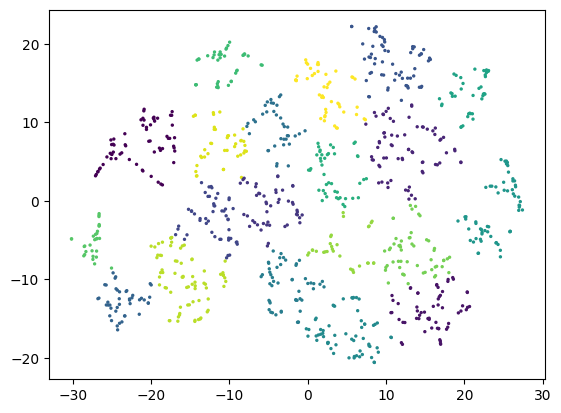

In [62]:
km = KMeans(n_clusters=20)
km.fit(comment_embedding_tsne)

plt.scatter(comment_embedding_tsne[:,0],
            comment_embedding_tsne[:,1], 
            s=2,
            c=km.labels_)

In [63]:
df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'label':km.labels_,
                                      'sentiment':small_train_dataset['label']})

In [64]:
df_comment_from_label.groupby('label')['sentiment'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
9,60.0,0.016667,0.129099
1,59.0,0.033898,0.182521
10,62.0,0.048387,0.216335
8,51.0,0.058824,0.237635
15,54.0,0.074074,0.264351
16,31.0,0.193548,0.401610
3,48.0,0.333333,0.476393
4,50.0,0.380000,0.490314
17,71.0,0.464789,0.502309


In [21]:
## T5-3b
#model_name = 'google-t5/t5-3b'
#model_path = cache_dir + '/models--google-t5--t5-3b/snapshots/bed96aab9ee46012a5046386105ee5fd0ac572f0'

# Mistral 7B
model_name = 'mistralai/Mistral-7B-v0.1'
model_path = cache_dir + '/models--mistralai--Mistral-7B-v0.1/snapshots/26bca36bde8333b5d7f72e9ed20ccda6a618af24'

In [12]:
# need this to get token to access a gated model
notebook_login()

In [22]:
AutoModelForClass = MistralForCausalLM
to_device = False
mistral_tokenizer, mistral_model = load_tokenizer_llm(AutoModelForClass, 
                                                      model_name, 
                                                      model_path, 
                                                      cache_dir, 
                                                      to_device=to_device,
                                                      load_in_4bit=True,
                                                      device_map='auto')

existing tokenizer found. Load from local
existing model found. Load from local


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
dataset['test']['text'][50]

'Our experience not so great.  We have mortgage as well as basic free checking and savings with Dollar in Squirrel Hill.  Mortgage application process was brutal.  Starting with the advertised rate of 2.85% being suddenly not available when we decided to lock it in; got 3.01%.  Automatic deduction of mortgage payment was required to secure this rate and it came out of the required Dollar checking account on the first business day of the month.  Free checking is free ... until.  Beware of Funds Availability policy.  We deposit a check monthly at the end of the month.  In August, the end of the month was a weekend and Labor Day was on September 1.  So our check did not get deposited until 9/2.  Mortgage payment hit on 9/2. It was paid, but we were charged $36 insufficient funds due solely to Funds Availability Policy.  After doing this first, Dollar then merrily hits us with two more $36 charges on smaller checks that would have cleared had they been processed before the mortgage payment

In [27]:
prompt = """ 
Describe the theme of the comment in one word.

Comment: {0}
Theme: healthcare

Comment: {1}
Theme: food

Comment: {2}
Theme: recreational

Comment: {3}
Theme: electronics

Comment: {4}
Theme:
""".format(dataset['train']['text'][0].strip(),
           dataset['train']['text'][4].strip(),
           dataset['train']['text'][8].strip(),
           dataset['train']['text'][10].strip(),
           dataset['test']['text'][50].strip())

In [28]:
prompt

' \nDescribe the theme of the comment in one word.\n\nComment: Unfortunately, the frustration of being Dr. Goldberg\'s patient is a repeat of the experience I\'ve had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don\'t get it.  You have office workers, you have patients with medical needs, why isn\'t anyone answering the phone?  It\'s incomprehensible and not work the aggravation.  It\'s with regret that I feel that I have to give Dr. Goldberg 2 stars.\nTheme: healthcare\n\nComment: All the food is great here. But the best thing they have is their wings. Their wings are simply fantastic!!  The \\""Wet Cajun\\"" are by the best & most popular.  I also like the seasoned salt wings.  Wing Night is Monday & Wednesday night, $0.75 whole wi

In [31]:
input_ids = mistral_tokenizer(prompt, return_tensors="pt").input_ids #.to(device)
with torch.no_grad():
    generated_ids = mistral_model.generate(input_ids, 
                                      do_sample=True,
                                      temperature=0.5,
                                      top_k=10,
                                      top_p=10,
                                      max_new_tokens=3)
    generated_text = t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


KeyboardInterrupt: 

Entering the prompt into ChatGPT, the performance is much better. Theme=customer service/banking/finance. 

### Validate topic labels using LDA/HDP